In [ ]:
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import re
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

## 1. 데이터 불러오기

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt") # train
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt") # test
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings.txt", filename="ratings.txt") # train + test

('ratings.txt', <http.client.HTTPMessage at 0x7fd00725e090>)

In [ ]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [ ]:
# train data의 상위 5개를 출력하세요.
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [ ]:
# train data의 문장갯수를 출력하세요.
len(train_data)
print(train_data.shape)
print(train_data.head())

(150000, 3)
         id                                           document  label
0   9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1   3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2  10265843                                  너무재밓었다그래서보는것을추천한다      0
3   9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4   6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1


## 2. 데이터 정제

In [ ]:
# train, test 모두 drop_duplicates를 활용하여 중복을 제거하세요.
train_data = train_data.drop_duplicates(subset=['document'])
test_data = test_data.drop_duplicates(subset=['document'])

In [ ]:
# train, test 모두 dropna(how='any')를 활용하여 결측치를 제거 하고 갯수를 출력하세요.
train_data = train_data.dropna(how ='any')
test_data = test_data.dropna(how='any')

print(len(train_data), len(test_data))

146182 49157


## 3. 토큰화 (sentencepiece활용)

In [ ]:
!pip install sentencepiece

In [ ]:
import sentencepiece as spm
temp_file = 'ratings_train.txt' # 네이버 영화리뷰 감성분석의 'document'컬럼을 txt로 만들고 input파일로 넣으세요.

vocab_size = 8000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --model_type=bpe --vocab_size={}'.format(temp_file, vocab_size)    
)
# model type : unigram , bpe, char, word

## 4. 인코딩 및 패딩설정

In [ ]:
def sp_tokenize(s, corpus):
    # sp_tokenize 함수 내에서 각 라인이 어떤일을 하는지 '자세히'주석을 달아주세요.
# """
# 이 함수는 니ㅏ런ㅇㄹㅇ리ㅏㅓㄴ 하는 역할을 하는 함수입니다.
# """


    tensor = [] # 텐서

    for sen in corpus: # 한 문장씩 분리하여 
        tensor.append(s.EncodeAsIds(sen)) # 텐서에 문장을 ids집합으로 토큰화하여 추가한다.

    with open("./korean_spm.vocab", 'r') as f: #korean_spm.vocab 파일을 한 줄씩 읽는다.
        vocab = f.readlines() #

    word_index = {} # 단어 중심
    index_word = {} # index 중심

    for idx, line in enumerate(vocab): # vocab 1줄씩 풀어서 idx와 문장으로 가져온다.
        word = line.split("\t")[0] # tab 기준으로 단어를 분리한다.

        word_index.update({idx:word}) #index와 단어를 추가
        index_word.update({word:idx}) #단어와 index를 추가

    # 배열 크기를 맞추기 위하여, 나머지 부분은 패딩을 post, 즉 뒤에 0으로 채워넣는다.
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post') 

    return tensor, word_index, index_word

In [ ]:
# train하고 test를 sp_tokenizer를 통과해주세요
sp = spm.SentencePieceProcessor()
sp.Load('korean_spm.model')

x_train_tensor, x_train_word_to_index, x_train_index_to_word = sp_tokenize(sp, train_data['document'])
x_test_tensor, x_test_word_to_index, x_test_index_to_word = sp_tokenize(sp, test_data['document'])

## 5. train data에서 validation data 분리

In [ ]:
# sklearn의 train_test_split으로 8:2로 분리도 가능!!
# from sklearn.model_selection import train_test_split

# x_train, x_valid, y_train, y_valid = train_test_split(train_data['document'], train_data['label'], test_size=0.2, shuffle=True, stratify=target, random_state=34)

# validation set 28000건 분리(전체 data의 약 20%)
x_val = x_train_tensor[:28000]
y_val = train_data['label'][:28000]

# validation set을 제외한 나머지 118182건
partial_x_train = x_train_tensor[28000:]
partial_y_train = train_data['label'][28000:]

print(x_val.shape, y_val.shape)
print(partial_x_train.shape, partial_y_train.shape)

(28000, 129) (28000,)
(118182, 129) (118182,)


In [ ]:
vocab_size = 8000
word_vector_dim = 16

## 6. 모델 설계

In [ ]:
model = keras.Sequential(name = 'LSTM')
model.add(
    keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,))
)
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.LSTM(32, return_sequences = True))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          128000    
                                                                 
 lstm (LSTM)                 (None, None, 32)          6272      
                                                                 
 dense (Dense)               (None, None, 32)          1056      
                                                                 
 dropout (Dropout)           (None, None, 32)          0         
                                                                 
 lstm_1 (LSTM)               (None, None, 32)          8320      
                                                                 
 dropout_1 (Dropout)         (None, None, 32)          0         
                                                                 
 dense_1 (Dense)             (None, None, 1)           33     

## 7. 모델 컴파일 및 모델 학습시작

In [ ]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['accuracy'])
epochs = 20
history = model.fit(partial_x_train, partial_y_train, epochs = epochs, batch_size=512, validation_data=(x_val, y_val), verbose=1 )

Epoch 1/10
231/231 [==============================] - 133s 505ms/step - loss: 0.5050 - accuracy: 0.7366 - val_loss: 0.3814 - val_accuracy: 0.8329
Epoch 2/10
231/231 [==============================] - 117s 508ms/step - loss: 0.3712 - accuracy: 0.8401 - val_loss: 0.3663 - val_accuracy: 0.8383
Epoch 3/10
231/231 [==============================] - 118s 509ms/step - loss: 0.3533 - accuracy: 0.8481 - val_loss: 0.3681 - val_accuracy: 0.8384
Epoch 4/10
231/231 [==============================] - 117s 508ms/step - loss: 0.3434 - accuracy: 0.8509 - val_loss: 0.3576 - val_accuracy: 0.8377
Epoch 5/10
231/231 [==============================] - 124s 538ms/step - loss: 0.3355 - accuracy: 0.8526 - val_loss: 0.3545 - val_accuracy: 0.8397
Epoch 6/10
231/231 [==============================] - 118s 512ms/step - loss: 0.3263 - accuracy: 0.8540 - val_loss: 0.3566 - val_accuracy: 0.8401
Epoch 7/10
231/231 [==============================] - 115s 497ms/step - loss: 0.3177 - accuracy: 0.8570 - val_loss: 0.3645 -

## 8.loss, accuracy 그래프 시각화

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


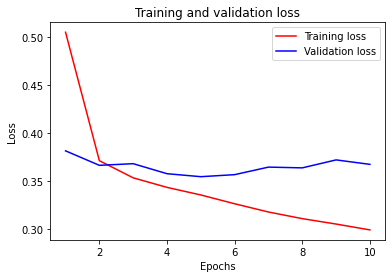

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, loss, 'r-', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

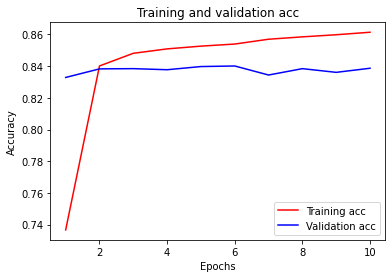

In [ ]:
plt.plot(epochs, acc, 'r-', label = 'Training acc')
plt.plot(epochs, val_acc, 'b', label = 'Validation acc')
plt.title('Training and validation acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# fit()주어진 입력(및 해당 교육 레이블)을 사용하여 모델을 교육하기 위한 것입니다.
# evaluate()검증(또는 테스트) 데이터와 해당 레이블을 사용하여 이미 훈련된 모델을 평가하기 위한 것입니다. 모델에 대한 손실 값 및 메트릭 값을 반환합니다.
# predict()실제 예측을 위한 것입니다. 입력 샘플에 대한 출력 예측을 생성합니다

y_test = test_data['label']

# 모델이 실전에 투입되었을 때 모델의 성능을 짐작
test_loss, test_acc = model.evaluate(x_test_tensor, y_test, verbose=2, steps = 10)

10/10 - 18s - loss: 0.3775 - accuracy: 0.8344 - 18s/epoch - 2s/step


In [ ]:
print(test_loss, test_acc)

0.37748149037361145 0.8344277739524841


In [ ]:
# 선형 데이터 예측할 때, 사용
test_predictions = model.predict(x_test_tensor)

print(test_predictions)

[[[0.85111064]
  [0.9282877 ]
  [0.9475182 ]
  ...
  [0.9835985 ]
  [0.9837645 ]
  [0.9839294 ]]

 [[0.58410054]
  [0.70115983]
  [0.8179214 ]
  ...
  [0.88077426]
  [0.880487  ]
  [0.88019884]]

 [[0.23649523]
  [0.22332752]
  [0.22573191]
  ...
  [0.50381356]
  [0.504088  ]
  [0.50436217]]

 ...

 [[0.55884886]
  [0.57745284]
  [0.8643887 ]
  ...
  [0.7605362 ]
  [0.76023936]
  [0.75994253]]

 [[0.46038538]
  [0.5149147 ]
  [0.5106456 ]
  ...
  [0.00653151]
  [0.00653982]
  [0.0065482 ]]

 [[0.4682976 ]
  [0.42641   ]
  [0.42956072]
  ...
  [0.56041247]
  [0.5605559 ]
  [0.56069833]]]


In [ ]:
len(test_predictions), len(x_test_tensor), len(y_test)

(49157, 49157, 49157)

In [ ]:
print(test_predictions.shape, y_test.shape)

(49157, 117, 1) (49157,)


ValueError: ignored

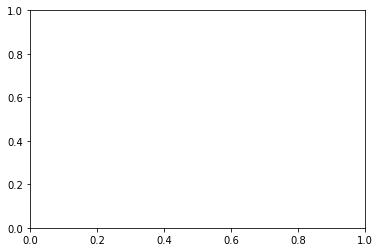